In [5]:
import define_transformations_afolu as dta
import define_transformations_circular_economy as dtc
import define_transformations_energy as dte
import define_transformations_ippu as dti

import os, os.path
import numpy as np
import pandas as pd
#from model_attributes import *
import model_attributes as ma
from attribute_table import AttributeTable
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import sisepuede_models as sm
import support_classes as sc
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import Union
import inspect
import ingestion as ing
import logging
from sisepuede_file_structure import *
import transformations_base_afolu as tba
import transformations_base_circular_economy as tbc
import transformations_base_energy as tbe
import transformations_base_general as tbg
import transformations_base_ippu as tbi


importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(tbc)
importlib.reload(tbe)



/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2431: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2236: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2431: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warni

<module 'transformations_base_energy' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/transformations_base_energy.py'>

# Temporary modification for Dave/WB 20230602
- adjust Montenegro CCSQ to lower magnitude
- adjust msp for hydrogen from electrolysis to ramp up much more quickly

In [81]:
vec_new_hydrogen = np.array([
    float(sf.vec_bounds((x - 9)/8, (0.0, 0.95)))
    for x in range(0, 36)
])
vec_new_ccsq_base = np.zeros(36)
vec_new_ccsq = 0.5*np.array([
    float(sf.vec_bounds((x - 9)/26, (0.0, 1.0)))
    for x in range(0, 36)
])

dict_fields_base_new = {
    "qty_ccsq_mt_co2_captured_sequestered_by_direct_air_capture": vec_new_ccsq_base
}

dict_fields_to_new = {
    "nemomod_entc_frac_min_share_production_fp_hydrogen_electrolysis": vec_new_hydrogen,
    "qty_ccsq_mt_co2_captured_sequestered_by_direct_air_capture": vec_new_ccsq
}


fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/ingestion/calibrated/montenegro/model_input_variables_montenegro_en_calibrated.xlsx"
dfs = pd.read_excel(fp, sheet_name = None);


# overwrite

all_fields = sorted(list(set(dict_fields_base_new.keys()) & set(dict_fields_to_new.keys())))
fields_repl = list(range(36))
for k, df in dfs.items():
    
    arr = np.array(df[fields_repl])
    
    if k == "strategy_id-0":
        for field, vec_new in dict_fields_base_new.items():
            ind = np.where(np.array(df["variable"] == field))[0][0]
            df.loc[ind, fields_repl] = vec_new

    else:  
        # check values
        for field, vec_new in dict_fields_to_new.items():

            if field in list(df["variable"]):
                ind = np.where(np.array(df["variable"] == field))[0][0]
                df.loc[ind, fields_repl] = vec_new
                
    dfs.update({k: df})


    


##  Check model of energy use

In [6]:
import sisepuede_data_api as api
importlib.reload(sc)
# initialize 
all_regions = None
dict_isos = {}
dict_sets = {}
field_country = "country"
field_iso = "iso_code3"
field_region = "nation"
field_year = "year"
fields_drop = [field_iso, field_region, field_year] # only apply later
field_time_period = sa.model_attributes.dim_time_period

# get some attributes
attr_region = sa.model_attributes.get_other_attribute_table(sa.model_attributes.dim_region)
attr_sector = sa.model_attributes.get_sector_attribute_table()
attr_strat = sa.model_attributes.get_dimensional_attribute_table(sa.model_attributes.dim_strategy_id)
attr_time_period = sa.model_attributes.get_dimensional_attribute_table(sa.model_attributes.dim_time_period)


time_periods = sc.TimePeriods(sa.model_attributes)
regions = sc.Regions(sa.model_attributes)


dir_git_sisepuede_data = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede_data"
repo = api.SISEPUEDEBatchDataRepository(
    dir_git_sisepuede_data,
    sa.model_attributes
)


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/support_functions.py:1210: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in df_in_grouped:
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/support_functions.py:1210: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in df_in_grouped:


In [7]:
# variables to read in (key) by categories (value)
from model_ippu import IPPU
model_ippu = IPPU(sa.model_attributes)
model_socioeconomic = model_ippu.model_socioeconomic

field_energy_new = "iea_consumption_pj_basic_metals"
field_gpc = "gdp_per_capita"
field_prod = "prodinit_ippu_metals_tonne"

dict_modvars = {
    #model_energy.modvar_scoe_consumpinit_energy_per_hh_heat: None,
    #model_energy.modvar_scoe_consumpinit_energy_per_hh_elec: None,
    #model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_elec: None,
    #model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_heat: None,
    model_ippu.modvar_ippu_prod_qty_init: None,
    model_ippu.model_socioeconomic.modvar_econ_gdp: None,
    #model_socioeconomic.modvar_gnrl_area: None,
    #model_socioeconomic.modvar_gnrl_elasticity_occrate_to_gdppc: None,
    #model_socioeconomic.modvar_gnrl_emission_limit_ch4: None,
    #model_socioeconomic.modvar_gnrl_emission_limit_co2: None,
    #model_socioeconomic.modvar_gnrl_emission_limit_n2o: None,
    #model_socioeconomic.modvar_gnrl_frac_eating_red_meat: None,
    #model_socioeconomic.modvar_gnrl_init_occ_rate: None,
    model_socioeconomic.modvar_gnrl_subpop: None,
}



df_inputs = repo.read(dict_modvars, add_time_periods = True)
df_inputs = time_periods.years_to_tps(df_inputs)


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:4000: UserWarning: clean_partial_category_dictionary: Invalid categories values 'chemicals', 'electronics', 'glass', 'lime_and_carbonite', 'metals', 'mining', 'paper', 'plastic', 'recycled_glass', 'recycled_metals', 'recycled_paper', 'recycled_plastic', 'recycled_rubber_and_leather', 'recycled_textiles', 'rubber_and_leather', 'textiles', 'wood' dropped when cleaning the dictionary. Category values not found.
  warnings.warn(f"clean_partial_category_dictionary: Invalid categories values {missing_vals} dropped when cleaning the dictionary. Category values not found.")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:4000: UserWarning: clean_partial_category_dictionary: Invalid categories values 'cement', 'electronics', 'glass', 'lime_and_carbonite', 'metals', 'mining', 'paper', 'plastic', 'recycled_glass', 'recycled_metals', 'recycled_paper', 'recycled_plastic', 

In [8]:

vec_gdp_per_capta = (10**9)*np.array(df_inputs["gdp_mmm_usd"])
vec_gdp_per_capta /= np.array(df_inputs[["population_gnrl_urban", "population_gnrl_rural"]]).sum(axis = 1)

df_inputs[field_gpc] = vec_gdp_per_capta
df_inputs.rename(columns = {"iso_code3": regions.field_iso}, inplace = True)



##  GET IEA ENERGY DATA

df_energy = pd.read_csv("/Users/jsyme/Downloads/iea_energy_metals.csv", skiprows = 1)
subsec = "Basic metals [ISIC 24]"
prod = "Total final energy use (PJ)"

df_energy["Product"] = [str(x).strip() for x in list(df_energy["Product"])]
df_energy = regions.data_func_iea_get_isos_from_countries(
    df_energy[
        df_energy["Subsector"].isin([subsec])
        & df_energy["Product"].isin([prod])
    ], 
    return_modified_df = True
)
df_energy = df_energy[
    [(len(x) == 3) for x in list(df_energy[regions.field_iso])]
]


fields_energy_dat = [x for x in df_energy.columns if str(x).isnumeric()]
df_energy_merge = pd.melt(
    df_energy[[regions.field_iso] + fields_energy_dat],
    id_vars = [regions.field_iso],
    value_vars = fields_energy_dat,
    var_name = time_periods.field_year,
    value_name = field_energy_new
)

df_energy_merge[time_periods.field_year] = df_energy_merge[time_periods.field_year].astype(int)

df_rels = pd.merge(df_inputs, df_energy_merge).dropna()
df_rels = df_rels[[x != ".." for x in list(df_rels[field_energy_new])]]
df_rels[field_energy_new] = df_rels[field_energy_new].astype(float)


vec_consump = np.array(df_rels[field_energy_new])
vec_prod = np.array(df_rels[field_prod])
vec_ratios = vec_consump/vec_prod


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/support_classes.py:423: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in[self.field_iso] = vec_iso


In [24]:
from sklearn.linear_model import LinearRegression

field_energy_new = "iea_consumption_pj_basic_metals"
field_gpc = "gdp_per_capita"
field_prod = "prodinit_ippu_metals_tonne"


arr_x = np.array(df_rels[[field_gpc, field_prod, time_periods.field_time_period]])
arr_y = np.array(df_rels[[field_energy_new]])


model = LinearRegression()
model.fit(arr_x[:, [1]], arr_y)

df_model = df_rels[[regions.field_iso, time_periods.field_time_period, field_prod, field_energy_new, field_gpc]]
df_model["ratio"] = 1000*np.array(df_rels[field_energy_new])/np.array(df_rels[field_prod])
df_model_avgs = (
    df_model[[regions.field_iso, "ratio"]]
    .groupby([regions.field_iso])
    .aggregate({regions.field_iso: "first", "ratio": "mean"})
    .reset_index(drop = True)
)
                   
                   
                   


LinearRegression()

(array([13., 13., 13.,  5.,  1.,  3.,  2.,  2.,  1.,  1.]),
 array([3.11498206e-05, 3.65033661e-03, 7.26952340e-03, 1.08887102e-02,
        1.45078970e-02, 1.81270838e-02, 2.17462706e-02, 2.53654574e-02,
        2.89846442e-02, 3.26038309e-02, 3.62230177e-02]),
 <BarContainer object of 10 artists>)

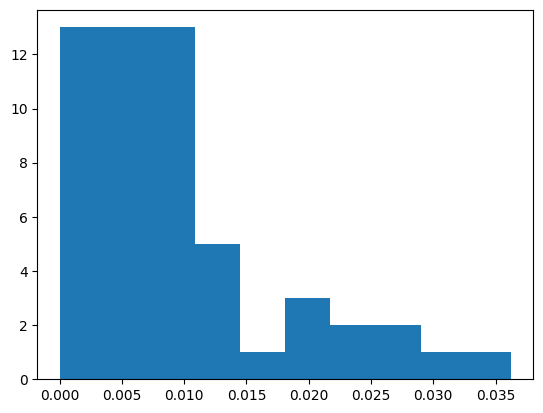

In [64]:
vec = sorted(list(df_model_avgs["ratio"]))[1:-2]
plt.hist(vec)

<AxesSubplot: xlabel='gdp_mmm_usd', ylabel='ratio'>

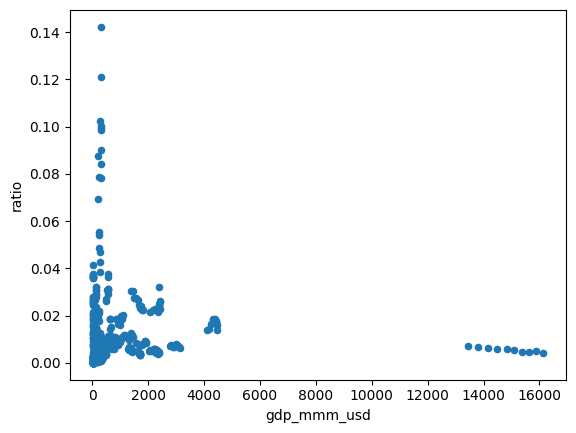

In [40]:
#df_model[[time_periods.field_time_period, "ratio"]].plot.scatter(x = time_periods.field_time_period, y = "ratio")




In [210]:
df_rels[regions.field_iso].unique()




array(['ALB', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BGR', 'BIH',
       'BLR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CYP', 'CZE', 'DEU',
       'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GRC', 'HRV',
       'HUN', 'IRL', 'ITA', 'JPN', 'KAZ', 'KGZ', 'KOR', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MEX', 'MKD', 'MLT', 'NLD', 'NOR', 'NZL',
       'POL', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR', 'UKR',
       'USA', 'UZB', 'ZAF'], dtype=object)

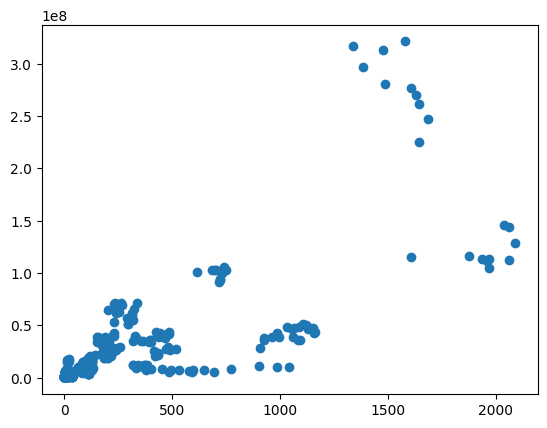

In [211]:
plt.scatter(vec_consump, vec_prod)

,Country,Subsector,Product,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,iso_alpha_3
239,Austria,Basic metals [ISIC 24],Total final energy use (PJ) ...,106.21,104.45,106.34,105.51,108.05,117.00,115.66,...,120.30,125.10,124.27,124.07,123.64,128.49,115.24,124.22,114.17,AUT
399,Belgium,Basic metals [ISIC 24],Total final energy use (PJ) ...,230.99,225.62,189.63,194.31,185.09,161.68,164.41,...,113.33,119.73,119.93,116.90,126.01,127.61,127.82,125.35,106.78,BEL
879,Denmark,Basic metals [ISIC 24],Total final energy use (PJ) ...,6.55,6.77,4.59,4.38,4.37,4.42,4.40,...,3.28,3.32,3.54,3.43,3.58,3.76,3.99,3.80,3.86,DNK
1039,Estonia,Basic metals [ISIC 24],Total final energy use (PJ) ...,0.02,0.04,0.06,0.07,0.06,0.09,0.17,...,0.15,0.11,0.11,0.06,0.08,0.06,0.08,0.07,0.07,EST
1199,Finland,Basic metals [ISIC 24],Total final energy use (PJ) ...,76.12,74.71,77.26,80.18,82.09,82.15,84.54,...,66.81,65.73,68.08,72.05,72.93,69.99,73.79,67.53,67.34,FIN
1519,Germany,Basic metals [ISIC 24],Total final energy use (PJ) ...,795.21,768.67,756.85,795.90,755.73,711.02,753.15,...,721.00,703.86,699.18,718.22,720.11,730.24,738.11,685.20,613.39,DEU
1839,Hungary,Basic metals [ISIC 24],Total final energy use (PJ) ...,49.57,43.35,43.50,43.52,41.61,42.31,45.75,...,35.56,27.77,29.05,34.19,28.58,35.85,37.55,34.59,30.82,HUN
1999,Ireland,Basic metals [ISIC 24],Total final energy use (PJ) ...,19.72,17.32,17.02,17.10,17.97,16.54,17.39,...,15.01,17.54,17.07,17.29,17.49,18.15,18.54,19.49,18.21,IRL
5359,Morocco,Basic metals [ISIC 24],Total final energy use (PJ) ...,..,..,..,..,5.28,5.67,5.87,...,7.38,7.36,7.26,7.32,7.23,8.21,8.17,8.33,7.72,MAR
5679,Ukraine,Basic metals [ISIC 24],Total final energy use (PJ) ...,914.85,931.68,908.37,909.21,1236.55,1125.59,1089.29,...,985.76,902.02,770.51,694.18,591.52,578.30,645.90,597.55,..,UKR
